In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.gridspec as gs
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LinearRegression
import pandas as pd
import csv,os

In [2]:
# Données pour estimer l'orientation
pi=np.pi
H_set_o=np.r_[0.01,0.25,0.35,0.45,0.5,0.65,0.75,0.85,0.99]
delta_set_o=np.r_[pi/64,9*pi/128,pi/8,3*pi/16,pi/4,5*pi/16,3*pi/8,7*pi/16,pi/2]
alpha_set_o=np.r_[-pi/2,-pi/6,0,pi/4,pi/3]
alpha_set_str_o=np.array(['-$\\frac{\pi}{2}$','-$\\frac{\pi}{6}$','0','$\\frac{\pi}{4}$','$\\frac{\pi}{3}$'],str)
delta_set_str_o=np.array(['$\\frac{\pi}{64}$','$\\frac{9\pi}{128}$','$\\frac{\pi}{8}$',
'$\\frac{3\pi}{16}$','$\\frac{\pi}{4}$','$\\frac{5\pi}{16}$','$\\frac{3\pi}{8}$','$\\frac{7\pi}{16}$','$\\frac{\pi}{2}$'],str)


# Données pour estimer H et delta
theta1=pi/2
H_set=np.r_[0.01,0.15,0.25,0.35,0.45,0.5,0.65,0.75,0.85,0.99]
delta_set=np.r_[pi/64,9*pi/128,pi/8,3*pi/16,pi/4,5*pi/16,3*pi/8,7*pi/16,pi/2]

delta_set_str=np.array(['$\\frac{\pi}{64}$','$\\frac{9\pi}{128}$','$\\frac{\pi}{8}$',
'$\\frac{3\pi}{16}$','$\\frac{\pi}{4}$','$\\frac{5\pi}{16}$','$\\frac{3\pi}{8}$','$\\frac{7\pi}{16}$','$\\frac{\pi}{2}$'],str)


# Chemin de sauvegarde des résultats
fil_dir='EF_param_estimation_by_Riesz/rslta_/partie2/'

# Code de chargement du champ
def load_img_200_of(H,delta,index,alpha=None):
    '''
    H: Rugosité du champ
    delta: Demi-ouverture du cone fréquentiel
    index: Numéro d'une realisation du champ
    alpha: Orientation du champ'''

    if alpha!=None:# estimation de alpha
        image_name='H='+str(H)+'_delta='+str(delta)+'_alpha='+str(alpha)+'_nb='+str(index)# Nom de l'image depuis le fichier pour estimer alpha
        title='H='+str(H)+'_delta='+str(np.round(delta,2))+'_alpha='+str(np.round(alpha,2))      # Nom de l'image à l'affichage
        fil_dir_200='EF_param_estimation_by_Riesz/200_realisations_of_each_EF_H_alpha_delta/'#fil_dir_200='img_revisions_Detec_img_param_by_Riesz.Copie/diff_200_realisations_of_each_EF_H_alpha_delta/'  
    else:# estimation de H et delta
        image_name='H='+str(H)+'_delta='+str(delta)+'_alpha='+str(delta)+'_nb='+str(index)# Nom de l'image depuis le fichier pour estimer H et delta
        title='H='+str(H)+'_delta='+str(np.round(delta,2))+'_alpha='+str(np.round(delta,2))
        fil_dir_200='EF_param_estimation_by_Riesz/200_realisations_of_each_EF_H_delta/'

    img_gray=np.load(fil_dir_200+image_name +'.npy')
    return img_gray,title

# Taille des image
img_shape=(256,256)

(-0.5, 255.5, 255.5, -0.5)

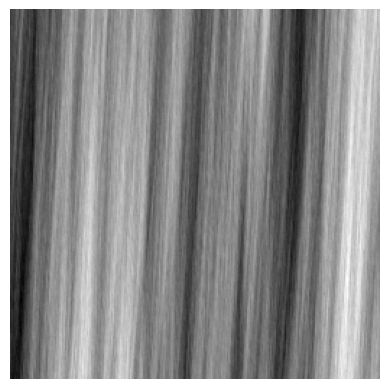

In [64]:
#################################### Chargement et affichage d'une l'image #######################################################
X,_=load_img_200_of(H=0.5,delta=pi/64,index=150)
plt.imshow(X,cmap='gray')
plt.axis('off')

In [6]:
######################## La transformée de Fourier du filtres F_l et H_l dans le domaine spectrale##############################
# c_n designe le coeffitient de normalisation fixé 0.014

def hat_F_l(img_shape,l,c_n=0.014):
    (M,N)=img_shape
    y=np.zeros((M,N))
    # Calcul des normes des arguments
    yy,xx=np.meshgrid(np.arange(-M//2,M//2),range(-N//2,N//2))  
    coord_norm=np.sqrt(xx**2+yy**2)
    # Calcul de la transformée de fourier de l'ondelette psi
    x=2**l*coord_norm*c_n
    a=(x<=pi)*(x>pi/4)
    y[a]=np.cos((pi/2)*np.log2(2*np.abs(x[a])/pi))
    return y

def hat_H_l(img_shape,l,c_n=0.014):
    (M,N)=img_shape
    y=np.zeros((M,N))
    # Calcul des normes des arguments
    yy,xx=np.meshgrid(np.arange(-M//2,M//2),range(-N//2,N//2))  
    coord_norm=np.sqrt(xx**2+yy**2)
    # Calcul de la transformee de fourier de l'ondelette
    x=2**l*coord_norm*c_n
    a=(x<=pi)*(x>pi/4)
    y[a]=np.cos((pi/2)*np.log2(2*np.abs(x[a])/pi)+pi)
    return y-y.min()

In [65]:
################### Affichage du filtre passe-bas F_l et du filtre passe-haut H_l associé dans le domaine spectrale aux échelles 1 et 2 #####################
def affiche_flters(img_shape,l=0):
    (M,N)=img_shape;l
    [W1,W2]=np.meshgrid(range(-M//2,M//2),range(-N//2,N//2))
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(221,projection='3d'); ax.plot_surface(W1,W2,hat_F_l(img_shape,l))
    ax.set_title('$|\hat{F}_{0}|$')
    ax=fig.add_subplot(222,projection='3d'); ax.plot_surface(W1,W2,hat_H_l(img_shape,l))
    ax.set_title('$|\hat{H}_{0}|$')
    ax=fig.add_subplot(223,projection='3d'); ax.plot_surface(W1,W2,hat_F_l(img_shape,l+1))
    ax.set_title('$|\hat{F}_{1}|$')
    ax=fig.add_subplot(224,projection='3d'); ax.plot_surface(W1,W2,hat_H_l(img_shape,l+1))
    ax.set_title('$|\hat{H}_{1}|$')
    fig.tight_layout(h_pad=5,w_pad=2)
    fig.savefig(fil_dir+'filtres')

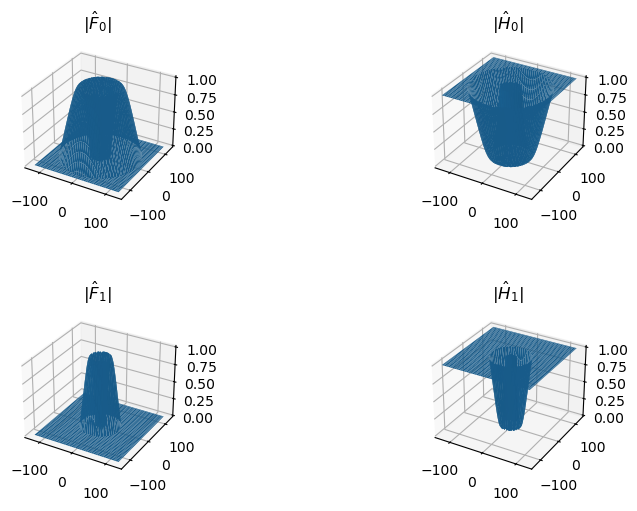

In [33]:
affiche_flters(img_shape,l=1)

In [6]:

def cor(X,l,c_n):
    '''
    Entrées:\n'
    X: Champ 2-D.\n
    l: Échelle.\n
    c_n: Coefficient de normalisation.\n
    Sorties:\n'
    Couple de champs (X1,X2) obtenus par filtrage de X respectivement par les ondelettes de Riesz 1 et 2.
    '''
    ################################################### Construction de la transformée de Fourier de l'ondelette hat_psi ##################################
    M,N=X.shape
    hat_psi=np.zeros((M,N))
    # Calcul des normes des arguments
    xx,yy=np.meshgrid(np.arange(-M//2,M//2),range(-N//2,N//2))  
    arg_norm=np.sqrt(xx**2+yy**2)
    coord_norm=np.fft.ifftshift(arg_norm)

    # Calcul de la transformée de fouriée de psi
    x=coord_norm*c_n
    t=(x<=pi)*(x>pi/4)
    hat_psi[t]=np.cos((pi/2)*np.log2(2*np.abs(x[t])/pi))

    ######################## Construction de la transformée de Fourier de Riesz #######################################
    hat_X_ctred=np.fft.fftshift(np.fft.fft2(X))
    xy_0=np.argwhere(arg_norm==0)[0]                                            # Prevoir l'indetermination a l'origne avant l'inversion
    arg_norm[xy_0[0],xy_0[1]]=1
    inv_arg_norm=1/arg_norm
    inv_arg_norm[[xy_0[0],xy_0[1]]]=0                                           # Prevoir l'indetermination a l'origne apres l'inversion

    hat_R1=np.fft.ifftshift(-1j*xx*inv_arg_norm*hat_X_ctred)                    # Coordonnées de Riesz 1
    hat_R2=np.fft.ifftshift(-1j*yy*inv_arg_norm*hat_X_ctred)                    # Coordonnées de Riesz 1

    ################################### Construction des Pas de translation de l'ondelette ###############################
    k1,k2=np.meshgrid(range(M),range(N))                                        
    pas=k1%M+(k2%N)*M                                                           
    pas_hat_psi_lk=((2**l)*pas)%(N*M)

    ################################### Construction des coefficients d'ondelette de Riesz ################################
    hat_coef_1=-(2**l)*hat_R1.flatten()[pas]*hat_psi.flatten()[pas_hat_psi_lk]
    hat_coef_2=-(2**l)*hat_R2.flatten()[pas]*hat_psi.flatten()[pas_hat_psi_lk]
    coef_0=np.fft.ifft2(hat_coef_1.reshape(M,N)).real                            # Coefficints d'ondelette de Riesz 1
    coef_1=np.fft.ifft2(hat_coef_2.reshape(M,N)).real                            # Coefficints d'ondelette de Riesz 2
    return coef_0,coef_1

In [7]:
################################### Construction du tenseur de structure de Riesz empirique ###########################

def tsore(X,l,c_n=0.014,rate=75):
    '''
    Entrées:\n'
    X: Champ 2-D.\n
    l: Échelle.\n
    c_n: Coefficient de normalisation.\n
    rate: Nombre de lignes et colonnes suprimées sur les bords de la texture filtrée pour réduire les artéfacts.\n
    Sorties:\n'
    Tenseur de structure en ondelettes de Riesz.
    '''
    
    M,N=X.shape
    coef_0,coef_1=cor(X,l,c_n,)
    cr0=coef_0[rate:-rate,rate:-rate];cr1=coef_1[rate:-rate,rate:-rate]             # Réduction des bords
    # Calcul des coefficients du tenseur de structure en ondelette Riesz empirique
    J_00=np.sum(cr0**2)
    J_01=J_10=np.sum(cr0*cr1)
    J_11=np.sum(cr1**2)
    t=np.array([[J_00,J_01],[J_10,J_11]])/(M*N)
    return t

In [20]:
X,_=load_img_200_of(H=0.25,delta=pi/8,index=125)
tsore(X,l=3,c_n=0.013,rate=75,)

array([[0.21080508, 0.07629946],
       [0.07629946, 0.08137747]])

5.2-1 a) *********************** **ESTIMATION DE LA RUGOSITE D'UN CHAMP ELEMENTAIRE** *****************************

In [ ]:
################## Détermination de l'ordre d'autosimilarité d'un EF par la régression linéaire ####################
# Ce code retourne la valeur optimale de H. Il retourne egalement la representation des nuages de points correspondant à la serie de valeurs propres
# et l'ordonnee  a l'origne optimale pour fig==True

def H_estimator(X,nb_scale=5,cv=3,c_n=0.014,fig=False): 
    '''
    Entrées:\n'
    X: Champ 2-D. \n
    nb_scale: Nombre d'échelle.\n 
    cv: Nombre de plits pour la validation croisée.\n
    c_n: Constante de normalisation.\n
    fig: Booléenne. Si 'True', la droite de régression est présentée. 'False' est la valeur par défaut.\n
    Sorties:\n'
    - Valeur optimale de l'ordre d'autosimilarité H.\n
    - Nuages de points correspondant à la serie des sommes de valeurs propres.\n
    '''
    scales=np.arange(1,nb_scale+1,dtype=int)
    y=np.zeros(len(scales),)                                                                               # Somme des log2 de valeurs propres par echelle.
    
    for i,l in enumerate(scales):
        vals_p=np.linalg.eigvals(tsore(X,l=l,c_n=c_n))
        y[i]=np.log2(vals_p.sum())

    # Prepation des donnees pour la regression
    x=scales.reshape(-1,1)
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.75,shuffle=False)
    scoring='neg_root_mean_squared_error'                                                                    # Choix de la mesure de performance

    # Entrainnement et ajustement du model
    Model=LinearRegression()
    result=cross_validate(Model,x_train,y_train,scoring=scoring,cv=cv,return_estimator=True)

    # Resultats des performances du model suivant les plits
    r=result['test_score'].round(3);n=np.argwhere(r==r.max())[0][0]
    p=result['estimator'][n]
    tild_H=p.coef_[0]/2-1 #estimateur de H
    tild_c=np.exp2(p.intercept_)#/tild_c_phi # estimateur l'intercept

    # Affichage de la droite de regression
    if fig==True:
        F,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,5))
        F.tight_layout(h_pad=1,w_pad=2)
        
        ax.scatter(scales,y,c='r')#ax.scatter(scales,tab[:,1])
        ax.plot(x,p.predict(x),c='b',label='$\\tilde{H}$='+str(np.round(tild_H,3)),ls='--')
        ax.set_xlabel('échelle l')
        ax.set_ylabel('log2($\\bar{s_{l}}$)')
        ax.set_title("Estimation de l'indice de Hurst H")# pour H="+str(H)+" & $\delta$="+ delta_set_str[delta_set==delta][0])
        ax.legend()
        F.savefig(fil_dir+'Estimation_H')
        tild_H=tild_H,tild_c

    return tild_H

(0.5872737334686438, 6.364582853119258e-05)

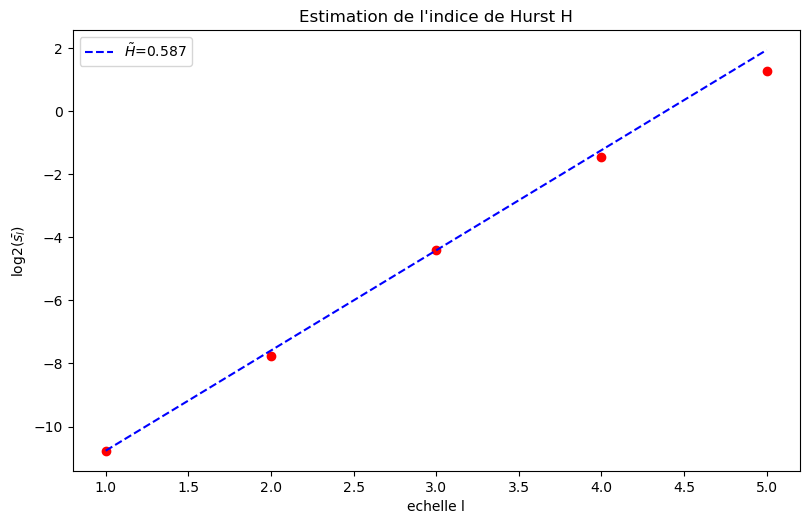

In [ ]:
X,_=load_img_200_of(H=0.5,delta=pi/8,index=121)
H_estimator(X,nb_scale=5,cv=3,c_n=0.014,fig=True,)# 0.014;

In [ ]:
##################################### Calcul de l'esperance de l'estimateur de H pour une valeur de delta #########################

def meanof_H_estimator(H,delta,nb_realst=25,nb_scale=5,cv=3,c_n=0.014):
    '''
    Entrées:\n'
    H: Ordre d'autosimilarité théorique\n
    delta: Degré d'anistropie théorique\n
    nb_realst: Nombre de réalisation du champ\n
    nb_scale: Nombre d'échelle \n
    cv: Nombre de plits pour la validation croisée \n
    c_n: Constante de normalisation \n
    Sortie:\n'
    Ordre d'autosimilarité moyen de la texture
    '''
    meanof_tild_H=0
    for index in range(nb_realst):
        X,_=load_img_200_of(H=H,delta=delta,index=index)
        h=H_estimator(X,nb_scale=nb_scale,cv=cv,c_n=c_n)
        meanof_tild_H+=h/nb_realst
    return meanof_tild_H
meanof_H_estimator(0.45,5*pi/16,nb_realst=25)

0.44658659510765863

In [ ]:
### Illustration graphique de l'efficacité de l'estimateur de H pour differentes valeurs de delta.

def AverageRoughness_index_estimator(nb_realst=25,nb_scale=5,cv=3):
    '''
    Entrées:\n'
    nb_realst: Nombre de réalisation du champ.\n
    nb_scale: Nombre d'échelle.\n
    cv: Nombre de plits pour la validation croisée.\n
    Sortie:\n'
    Figure illustrative de l'efficacité de l'estimateur à estimer, par sa moyenne, l'ordre d'autosimilarité des textures.
    '''

    fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,5))
    couleurs=[(1,0,0.5),'k','g','r','c','m','y','b','0.5',(0.95,0.5,1)]
    h=np.zeros((len(delta_set),))                                     
    for j,H in enumerate(H_set):
        for i,delta in enumerate(delta_set):
            h[i]=meanof_H_estimator(H,delta,nb_realst,nb_scale,cv)     # Calcul des valeurs moyennes estimées à chaque delta

        ax.plot(delta_set,h,c=couleurs[j])                            # Tracé de la valeur moyenne estimée de H en fonction de delta
        ax.axhline(H,label='H='+str(H),ls='--',c=couleurs[j])         # Tracé de la valeur cible H en fonction de delta
        
    ax.set_title("Valeur moyenne de $\\tilde{H}$")
    ax.set_xticks(ticks=delta_set,labels=delta_set_str)
    ax.set_yticks(ticks=H_set,labels=H_set.astype(str))
    ax.set_ylabel("Valeur cible")
    ax.set_xlabel("Degé d'anisotropie $\delta$")
    ax.legend()
    fig.savefig(fil_dir+'Val_moy_tild_H')

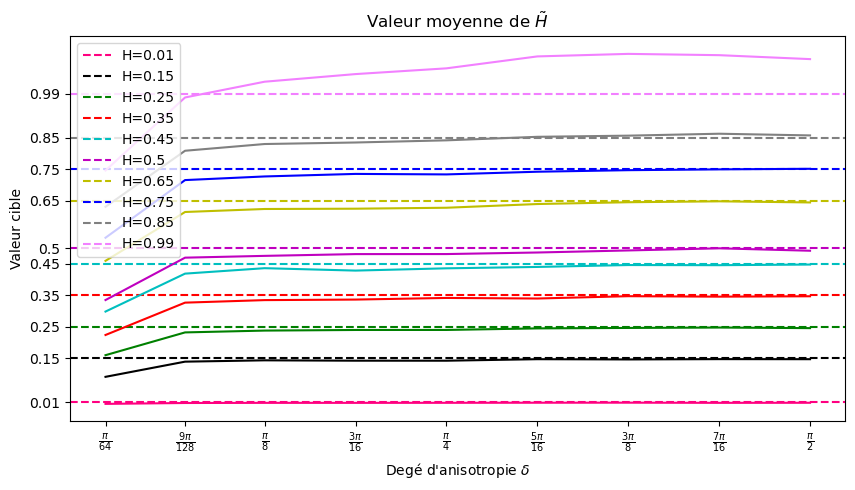

In [70]:
AverageRoughness_index_estimator(nb_realst=200,nb_scale=5,cv=3)#25/15mn*******************2h

Cette figure illustre une estimation de l'indice de Hurst moyen en fonction du degré d'anisotropie pour differentes valeurs de H, caracterise par une couleur. 
Nous nous attendons a une valeur estimée constante pour chaque H caracterise par une couleur.
- l'estimation est satisfaisante pour un degré d'anisotropie supérieur à $\frac{9\pi}{128}$ et  H<0.99.
- Ces mauvais resultats:
    - par rapport au degré d'anisotropie, est du fait d'une faible énergie,dans le domaine frequentiel, de la texture filtrée.
    - pour H=0.99 est du fait d'un lissage trop forte de la texture.
- Plus la ligne en trait plein est proche de celle en tirait plus l'estimateur est efficace(Notion justifiée par les taleaux de MSE et VE ci-dessous)

In [ ]:
# Calcul de la moyenne quadratiue(Mse) et de la variance empirique(ve)
def mse_ve_tild_H(nb_realst=25,nb_scale=5,cv=3):
    '''
    Entrées:\n'
    nb_realst: Nombre de réalisation du champ\n
    nb_scale: Nombre d'échelle \n
    cv: Nombre de plits pour la validation croisée \n
    Sortie:\n'
    Deux tableaux contenant respectivement les erreurs moyennes quadratiques et les variances empiriques de l'estimateur de l'ordre d'autosimilarité 
    pour chaque texture de paramètres théoriques H et delta
    '''
    
    MSE=np.zeros((len(H_set),len(delta_set)));VE=np.zeros((len(H_set),len(delta_set)))
    
    for i,H in enumerate(H_set):
        for j,delta in enumerate(delta_set):
            mean=meanof_H_estimator(H,delta,nb_realst,nb_scale,cv)           # Calcule de  de lesperance de l'estimateur(moyenne empirique de tild_H)
            ve=0;mse=0
            for index in range(nb_realst):
                X,_=load_img_200_of(H=H,delta=delta,index=index)
                tild_H=H_estimator(X)                                   # Calcul d'une valeur de H estimée
                ve+=(tild_H-mean)**2/nb_realst                              # Calcul de la variance empirique
                mse+=(tild_H-H)**2/nb_realst                                # Calcul de l'erreur moyenne quadratique

            MSE[i,j]=mse;VE[i,j]=ve
        
    return  pd.DataFrame(MSE,index=H_set,columns=delta_set_str),pd.DataFrame(VE,index=H_set,columns=delta_set_str)

In [43]:
#MSE,VAR=mse_var_meanof_tild_H(nb_realst=200)# 10/11mn ******************** 3,67h
#MSE.round(5).to_csv(fil_dir+'mse_tild_H.csv',sep=';',index=True,header=True)
#VAR.round(5).to_csv(fil_dir+' var_tilde_H.csv',sep=';',index=True,header=True)

In [46]:
mse=pd.read_csv(fil_dir+'mse_tild_H.csv',sep=";")
mse

Unnamed: 0  $\frac{\pi}{64}$  $\frac{9\pi}{128}$  $\frac{\pi}{8}$  \
0        0.01           0.00005             0.00002          0.00002   
1        0.15           0.00470             0.00101          0.00044   
2        0.25           0.01142             0.00167          0.00097   
3        0.35           0.02111             0.00339          0.00152   
4        0.45           0.03147             0.00502          0.00247   
5        0.50           0.03876             0.00521          0.00292   
6        0.65           0.04932             0.00753          0.00372   
7        0.75           0.06364             0.00659          0.00449   
8        0.85           0.06765             0.00931          0.00446   
9        0.99           0.08460             0.00822          0.01065   

   $\frac{3\pi}{16}$  $\frac{\pi}{4}$  $\frac{5\pi}{16}$  $\frac{3\pi}{8}$  \
0            0.00002          0.00002            0.00002           0.00002   
1            0.00033          0.00023            0.00024           0.00016   
2            0.00074          0.00054            0.00043           0.00035   
3            0.00127          0.00105            0.00067           0.00061   
4            0.00180          0.00130            0.00095           0.00079   
5            0.00211          0.00147            0.00114           0.00111   
6            0.00269          0.00237            0.00148           0.00122   
7            0.00289          0.00210            0.00205           0.00163   
8            0.00313          0.00248            0.00293           0.00227   
9            0.01568          0.02372            0.03545           0.03498   

   $\frac{7\pi}{16}$  $\frac{\pi}{2}$  
0            0.00002          0.00002  
1            0.00015          0.00013  
2            0.00033          0.00030  
3            0.00051          0.00046  
4            0.00066          0.00058  
5            0.00081          0.00067  
6            0.00105          0.00081  
7            0.00122          0.00113  
8            0.00187          0.00143  
9            0.03345          0.03009

In [50]:
var=pd.read_csv(fil_dir+'var_tilde_H.csv',sep=';')
var

Unnamed: 0  $\frac{\pi}{64}$  $\frac{9\pi}{128}$  $\frac{\pi}{8}$  \
0        0.01           0.00003             0.00002          0.00002   
1        0.15           0.00126             0.00090          0.00040   
2        0.25           0.00334             0.00136          0.00083   
3        0.35           0.00530             0.00286          0.00130   
4        0.45           0.00855             0.00406          0.00229   
5        0.50           0.01161             0.00429          0.00232   
6        0.65           0.01309             0.00629          0.00306   
7        0.75           0.01657             0.00544          0.00399   
8        0.85           0.01979             0.00765          0.00408   
9        0.99           0.02536             0.00809          0.00917   

   $\frac{3\pi}{16}$  $\frac{\pi}{4}$  $\frac{5\pi}{16}$  $\frac{3\pi}{8}$  \
0            0.00002          0.00002            0.00002           0.00002   
1            0.00028          0.00018            0.00023           0.00015   
2            0.00064          0.00044            0.00041           0.00034   
3            0.00109          0.00098            0.00057           0.00060   
4            0.00135          0.00110            0.00086           0.00078   
5            0.00176          0.00111            0.00095           0.00105   
6            0.00208          0.00190            0.00138           0.00120   
7            0.00269          0.00185            0.00200           0.00163   
8            0.00292          0.00242            0.00292           0.00222   
9            0.01176          0.01718            0.02134           0.01889   

   $\frac{7\pi}{16}$  $\frac{\pi}{2}$  
0            0.00002          0.00002  
1            0.00015          0.00013  
2            0.00033          0.00028  
3            0.00049          0.00045  
4            0.00064          0.00057  
5            0.00081          0.00060  
6            0.00105          0.00079  
7            0.00122          0.00112  
8            0.00170          0.00137  
9            0.01838          0.01794

**Remarque:** Plus la texture est isotrope plus l'estimateur est efficace

5.2-1 b) ****** **ESTIMATION DE L'INDICE DE D'UN CHAMP ELEMENTAIRE SUIVANT L'ECHELLE** ***********************

In [23]:
######## Calcul de la moyenne empirique de l'estimateur de l'indice de cohérence par échelle pour une valeur de H

def meanof_constcy_estimator_per_scale(H,delta,nb_realst=25,nb_scale=5,c_n=0.014):
    '''
    Entrées:\n'
    H: L'ordre d'autosimilarité théorique\n
    delta: Degré d'anisotropie théorique\n
    nb_realst: Nombre de réalisation du champ\n
    nb_scale: Nombre d'échelle \n
    c_n: Constante de normalisation \n
    Sortie:\n'
    Tableau contenant l'indice de cohérence moyen des textures de la base de donnée 
    '''
    scales=np.arange(1,nb_scale+1,dtype=int)
    meanof_ic_per_scale=np.zeros(nb_scale,)  # moyenne de l'estimateur de l'indice de coherence par echelle
    
    for i,l in enumerate(scales):
        for index in range(nb_realst):
            X,_=load_img_200_of(H=H,delta=delta,index=index)
            vals_p=np.linalg.eigvals(tsore(X,l=l,c_n=c_n))
            meanof_ic_per_scale[i]+=((vals_p.max()-vals_p.min())/vals_p.sum())/nb_realst                   
    return meanof_ic_per_scale

meanof_constcy_estimator_per_scale(0.5,delta=pi/64,nb_realst=1,nb_scale=5,c_n=0.014)

array([0.92007508, 0.92532263, 0.97465444, 0.92512572, 0.95279586])

In [ ]:
## Comparaison graphique de l'indice de chérence moyen à l'indice de cohérence cible à chaque échelle.

def compare_AverageConstcy_index_to_constcy_index(H,nb_realst=24,c_n=0.014,nb_scale=5,best_scale=None):
    '''
    Entrées:\n'
    H: L'ordre d'autosimilarité des textures
    nb_realst: Nombre de réalisation du champ\n
    nb_scale: Nombre d'échelles \n
    best_scale: L'échelle adéquate. 'None' par défaut \n
    Sortie:\n'
    Figure comparant l'estimateur moyen de l'indice de cohérence à sa valeur cible
    '''
    fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,5))
    couleurs=[(1,0,0.5),'k','g','r','c','m','y','b','0.5','0.95']
    scales=np.arange(1,nb_scale+1)
    #meanof_ic_per_scale=np.zeros(nb_scale,)
    for i,delta in enumerate(zip(delta_set,delta_set_str)):
        meanof_ic_per_scale=0
        meanof_ic_per_scale=meanof_constcy_estimator_per_scale(H,delta[0],nb_realst,nb_scale,c_n)            # Calcul de la moyennes empirique de l'estimateurs de l'indice de chérence      
        ax.plot(scales,meanof_ic_per_scale,c=couleurs[i])                                               # Tracé de la moyenne empirique de l'estimateur de l'indice de cohérence
        ax.axhline(np.sin(2*delta[0])/(2*delta[0]),label='$\delta$='+delta[1],ls='--',c=couleurs[i])    # Tracé de l'indice de cohérence cible
        if best_scale!=None:
            ax.scatter(best_scale,meanof_ic_per_scale[best_scale-1],c='k')                              # marquage de l'échelle adéquate
    ax.set_title("Comparaison de l'estimateur de l'indice de cohérence moyen à la valeur cible pour H="+str(H))
    ax.set_xlabel("Échelle")
    ax.set_ylabel("Indice de cohérence cible")
    ax.legend()#loc="upper left",bbox_to_anchor=(1,1))
    fig.savefig(fil_dir+'Val_moy_tild_ic'+str(H))

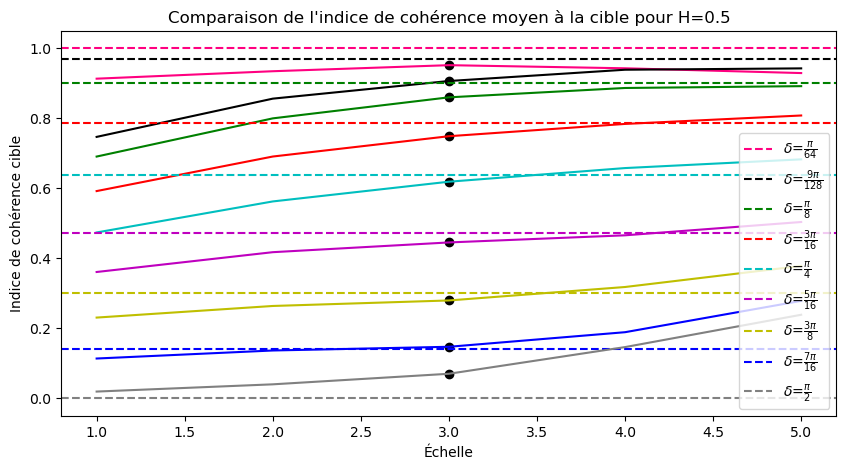

In [ ]:
compare_AverageConstcy_index_to_constcy_index(H=0.5,nb_realst=25,c_n=0.014,nb_scale=5,best_scale=3)

Cette figure illustre une estimation de l'indice de cohérence moyen en fonction des échelles pour différents degrés d'anisotropie caracterisées par des couleurs. Et ce, pour H=0.5.
Nous nous attendons a une valeur estimée constante pour chaque degré d'anisotropie.
- Plus la ligne en trait plein est proche de celle en tirait plus l'estimateur est efficace.
- l'estimation n'est satisfaisante qu'à l'échelle 3. Cette échelle sera l'échelle adéquate.
- Ce mauvais resultat par rapport échelles, est certainement du fait d'une faible ou forte énergie,dans le domaine frequentiel, de la texture filtrée.

In [ ]:
# Visualisation de la capacité de l'estimateur moyen de l'indice de chérence en foncion de delta à l'échelle 3 pour 
# différentes valeurs de H.

def AverageConstcy_index_estimator(nb_realst,l=3):
    '''
    Entrées:\n'
    nb_realst: Nombre de réalisation du champ\n
    l: Échelle adéquate\n
    Sortie:\n'
    Figure illustrative de l'éfficacité de l'estimateur à estimer, par sa moyenne, l'indice de cohérence des textures
    '''

    couleurs=[(1,0.75,0.5),'0.35','g','r','c','m','y','b','0.5',(0.25,0.25,0.5)]
    
    for j,H in enumerate(H_set):
        meanof_ic_per_delta=np.zeros(len(delta_set),)
        for i,delta in enumerate(delta_set):
            for index in range(nb_realst):
                X,_=load_img_200_of(H=H,delta=delta,index=index) # Chargement du champ 
                vals_p=np.linalg.eigvals(tsore(X,l=3))
                meanof_ic_per_delta[i]+=((vals_p.max()-vals_p.min())/vals_p.sum())/nb_realst # Calcul de l'indice de chérence moyen à chaque  delta
            
        plt.plot(delta_set,meanof_ic_per_delta,label='H='+str(H),c=couleurs[j]) # Tracé de l'indice de chérence moyen  pour chaque H
    plt.xticks(ticks=delta_set,labels=delta_set_str)
    plt.title("Estimateur de l'indice de coherence moyen à l'echelle l="+str(l))
    plt.xlabel("Degré d'anisotropie $\\delta$")
    plt.ylabel("Indice de cohérence cible")
    plt.legend()
    plt.savefig(fil_dir+'Val_moy_tild_ic'+str(l))

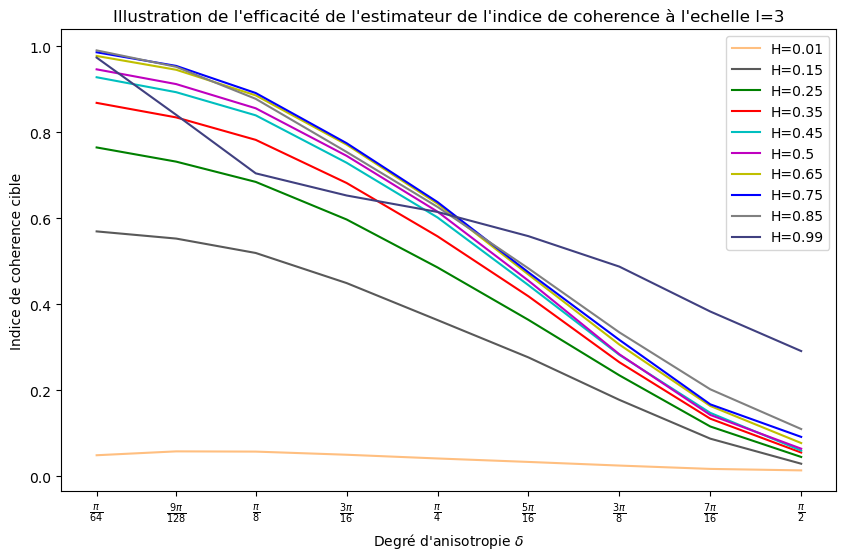

In [ ]:
plt.figure(figsize=(10,6))
AverageConstcy_index_estimator(nb_realst=200,l=3)

**Remarque:** Plus H est éloigné de 0 et 1 plus l'estimateur est efficace (0.35<H<0.85) 

5.3 a) ****************** **ESTIMATIMATION DE L'ORIENTATION DOMINANTE D'UN CHAMP ELEMENTAIRE** **********************

In [3]:
def alpha_estimator(X,l=3,c_n=0.014):
        '''
    Entrées:\n'
    X: Champ 2-D \n
    c_n: Constante de normalisation \n
    l: Échelle adéquate\n
    Sortie:\n'
    Orientation empirique du champ 2-D
    '''
        val_p,vect_p=np.linalg.eig(tsore(X,l,c_n))
        vect_p_max=vect_p[:,np.argmax(val_p)]
        return np.arctan(vect_p_max[1]/vect_p_max[0]) 

In [ ]:
X,_=load_img_200_of(H=0.5,delta=5*pi/16,alpha=0.0,index=98)
alpha_estimator(X,l=3,c_n=0.014)

0.07425703343929697

In [8]:
# Visualisation de l'histogramme empirique des orientations locales d'un champ élémentaire et son orientation empirique. 

def show_OE_emphists_OL(X,title=None,c_n=0.014,l=3):
    '''
    Entrées:\n'
    X: Champ 2-D \n
    title: Nom du champ. La valeur par défaut est "None" \n
    c_n: Constante de normalisation \n
    l: Échelle adéquate\n
    Sortie:\n'
    Histogramme empirique des orientations locales de la textue du champ et son orientation empirique
    '''
    fig=plt.figure(figsize=(10,4))
    
    cr1,cr2=cor(X,l,c_n)                      
    orientations=np.arctan2(cr2,cr1).flatten()                                            # Calcul des orientations locales  empiriques du champ
        
    orientation_emp=alpha_estimator(X,l,c_n)                                              # Calcul de l'orientation empirique du champ

    # Affichage du champ
    ax=fig.add_subplot(1,2,1)
    ax.set_title(title)
    ax.imshow(X,cmap='gray')
    ax.set_axis_off()
    ax=fig.add_subplot(1,2,2)
    ax.set_title('Histogramme empirique des Orientations'); plt.hist(orientations,bins=50,density=True) # Tracé de l'histogramme empirique des orientations
    ax.axvline(orientation_emp,c='r',label='orientation empirique: '+str(np.round(orientation_emp,2))) # Tracé de l'orientation empirique
    ax.legend()
    fig.tight_layout(h_pad=1,w_pad=1)
    fig.savefig(fil_dir+'Hist_emp_o_H='+str(H)+'_alpha='+str(alpha_set_o[alpha_set_o==alpha].round(2)[0])
                +'_delta='+str(delta_set_o[delta_set_o==delta].round(2)) +'.png')

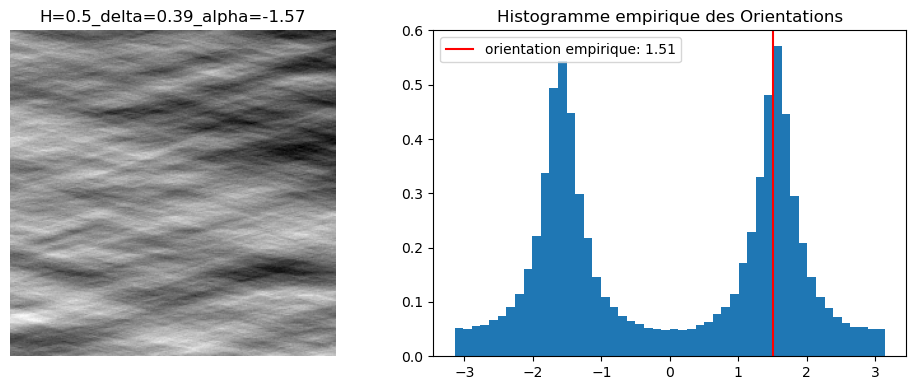

In [30]:
X,title=load_img_200_of(H=0.5,delta=pi/8,alpha=-pi/2,index=10)  
show_OE_emphists_OL(X,title=title,)

5 3a-1) **Évaluation de la qualité de l'orientation empirique à capter l'orientation dominante de la distribution empirique des orientations**

In [29]:
alpha=0.0;index=0

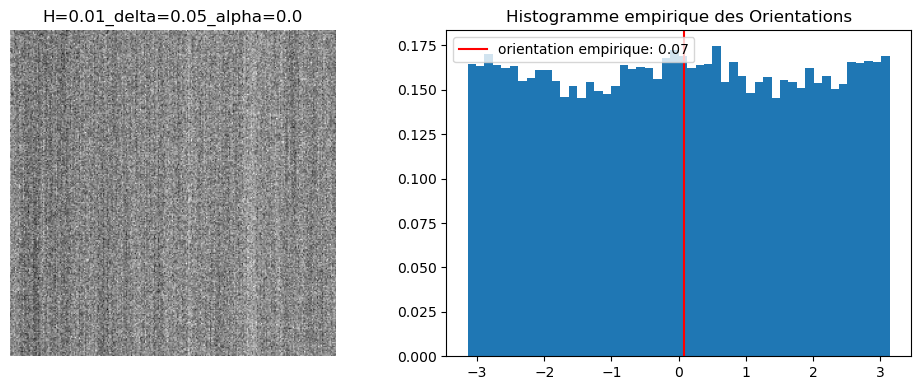

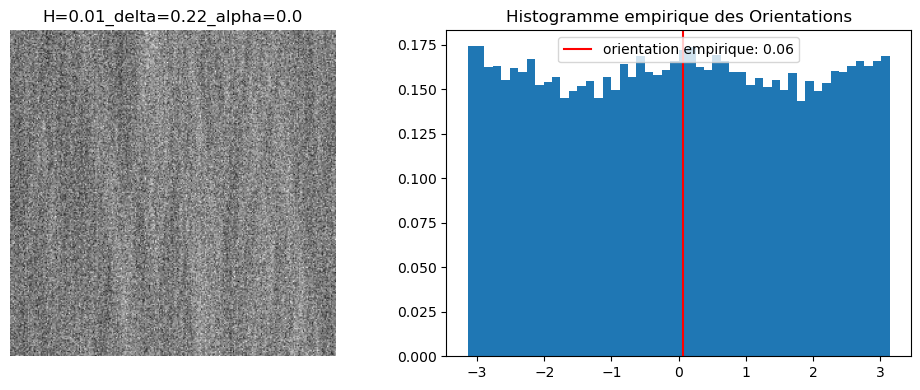

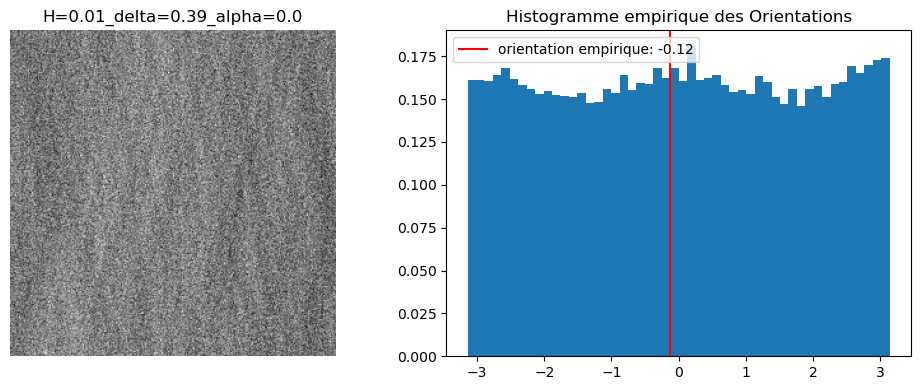

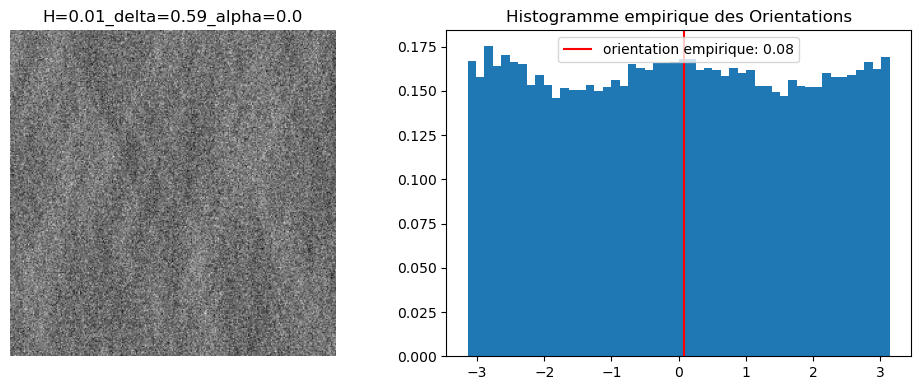

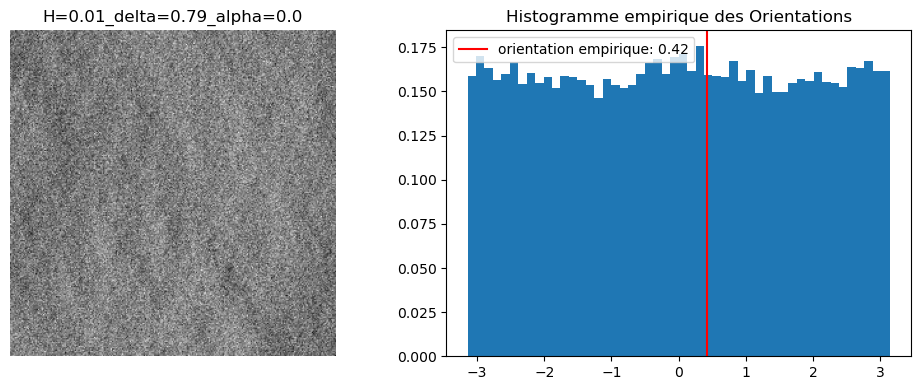

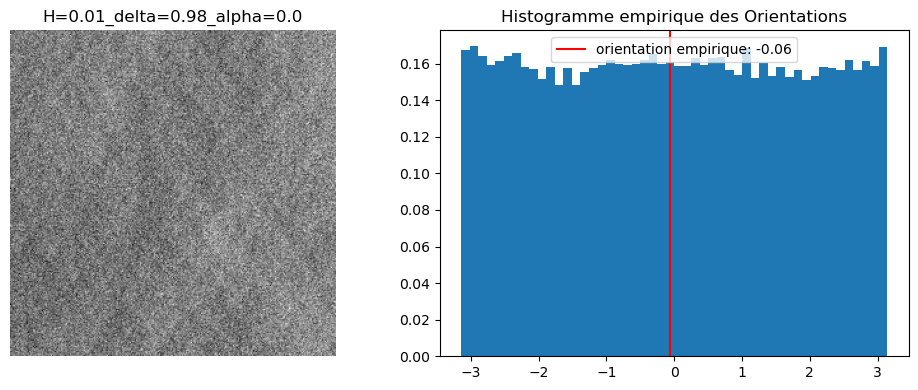

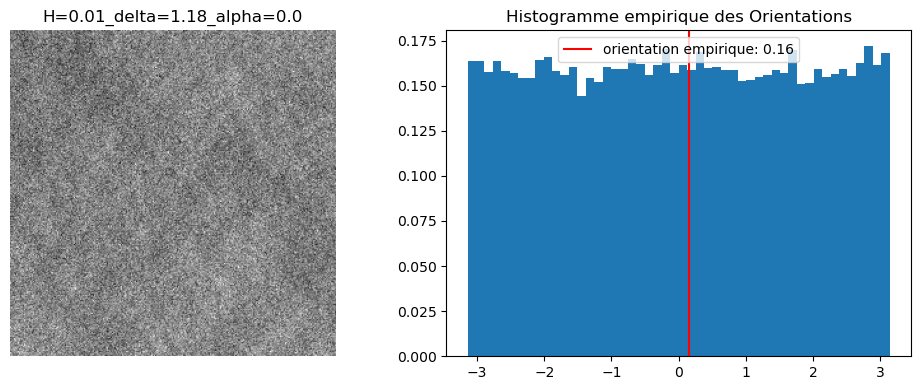

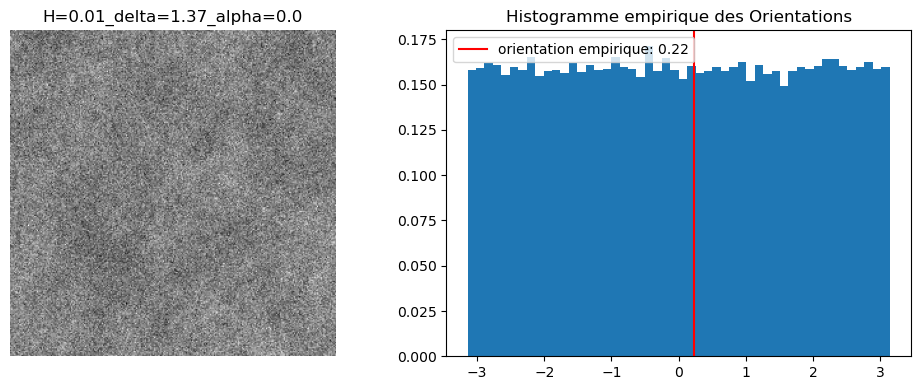

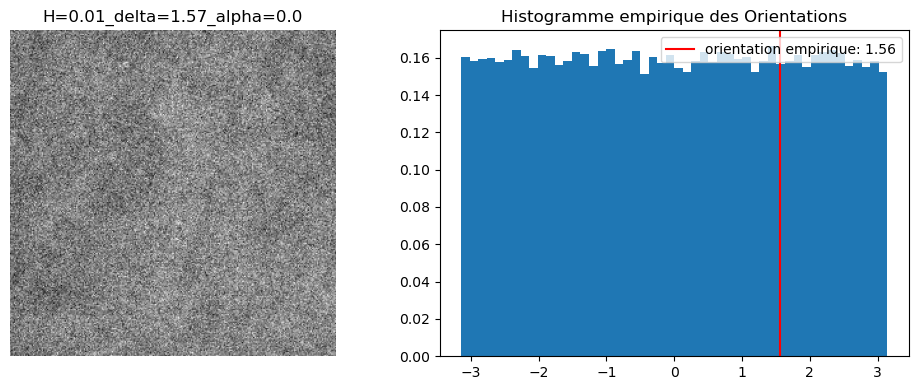

In [42]:
for delta in delta_set:
        X,title=load_img_200_of(H=0.01,delta=delta,alpha=alpha,index=index)
        show_OE_emphists_OL(X,title=title)

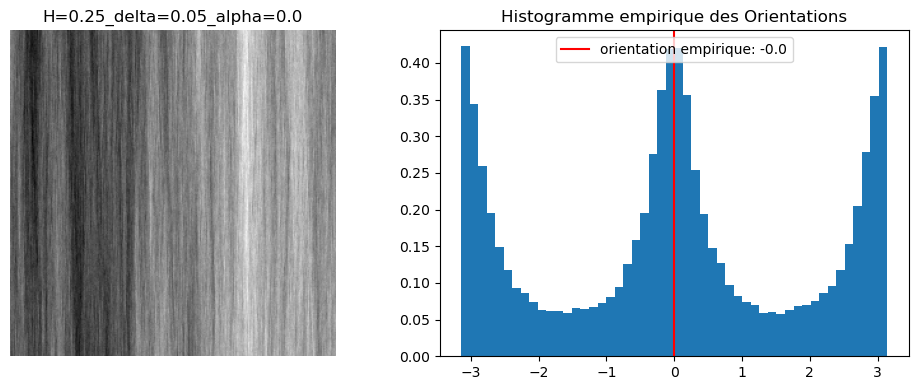

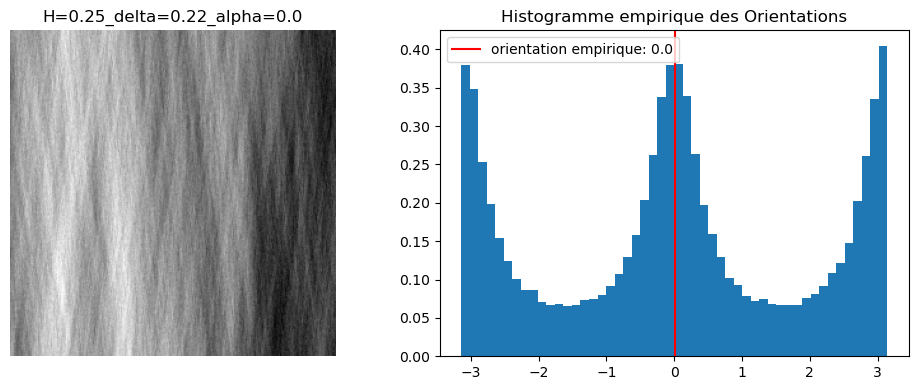

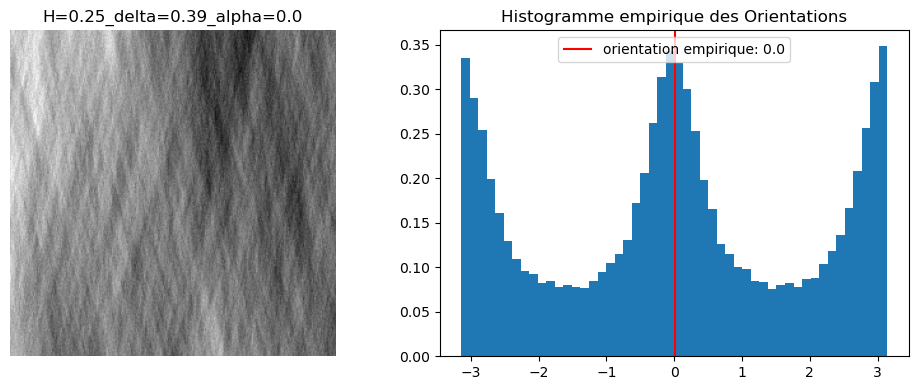

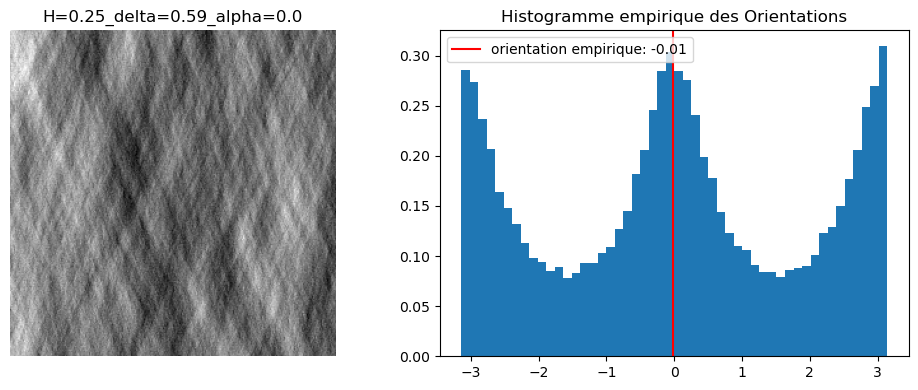

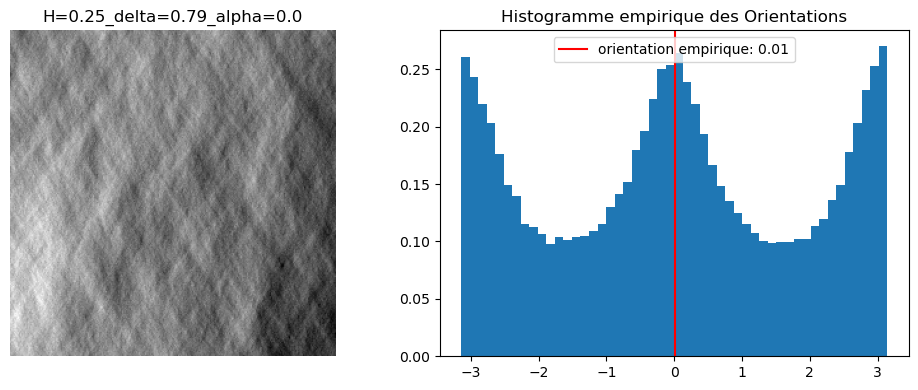

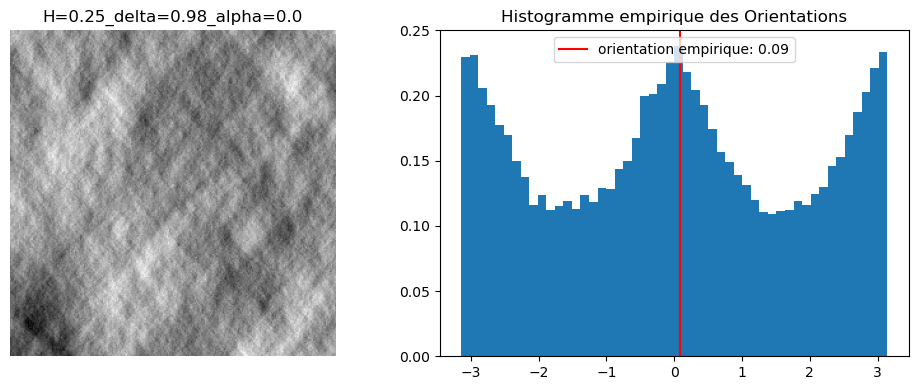

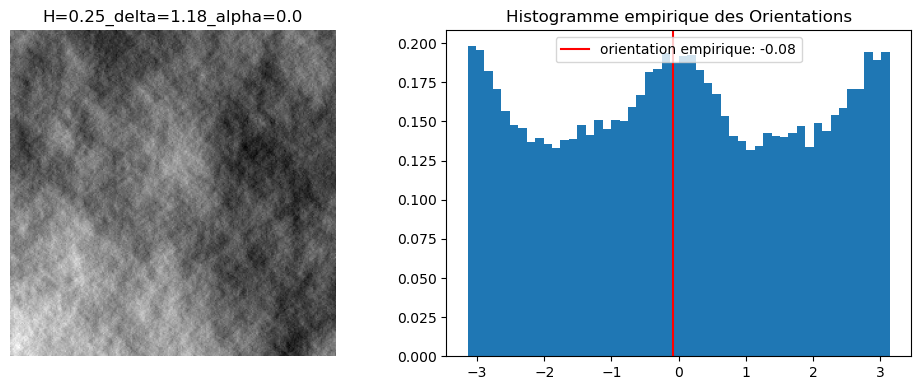

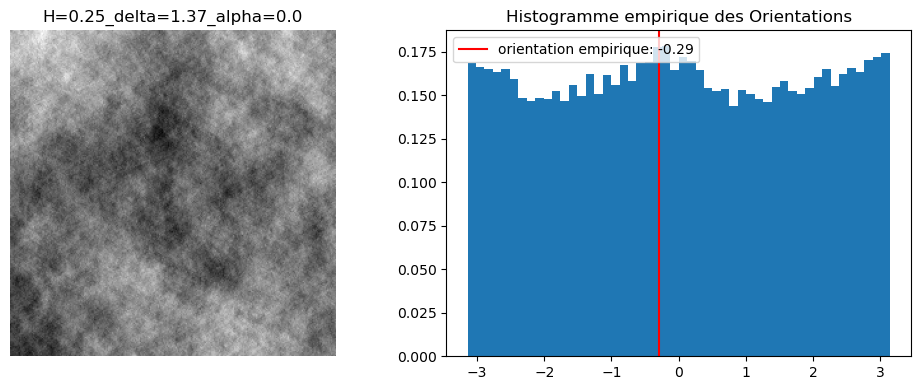

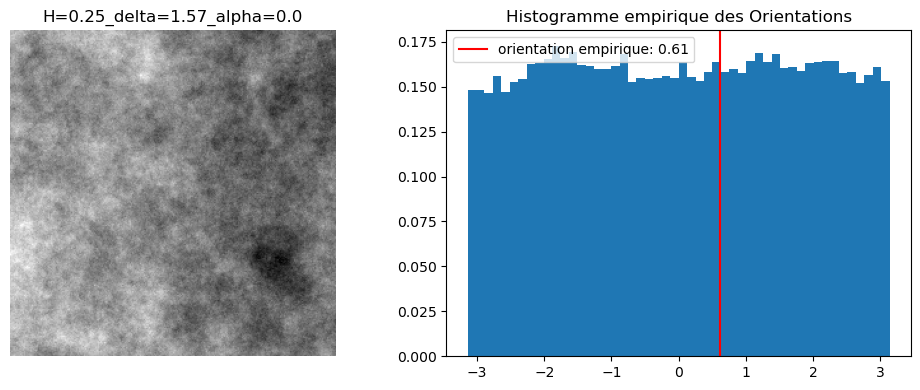

In [43]:
for delta in delta_set:
        X,title=load_img_200_of(H=0.25,delta=delta,alpha=alpha,index=index)
        show_OE_emphists_OL(X,title=title)

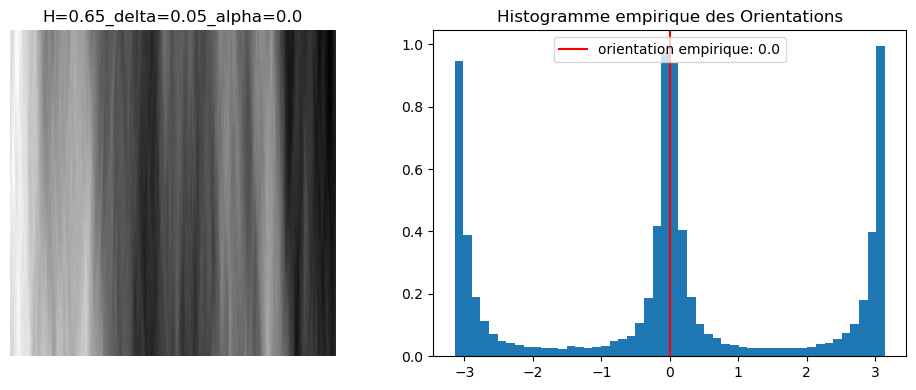

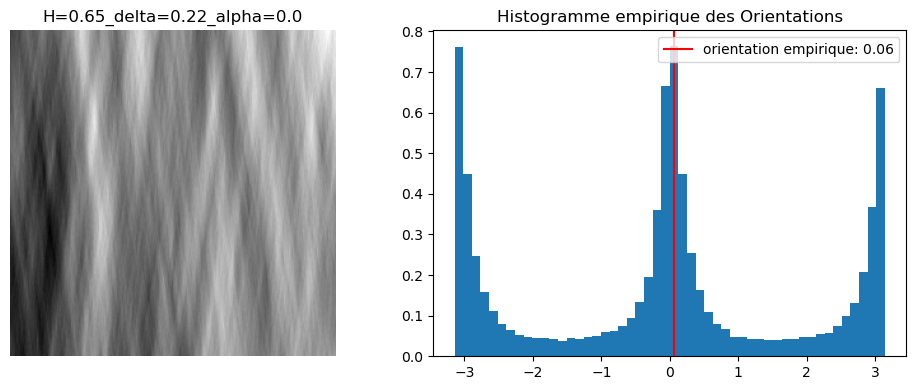

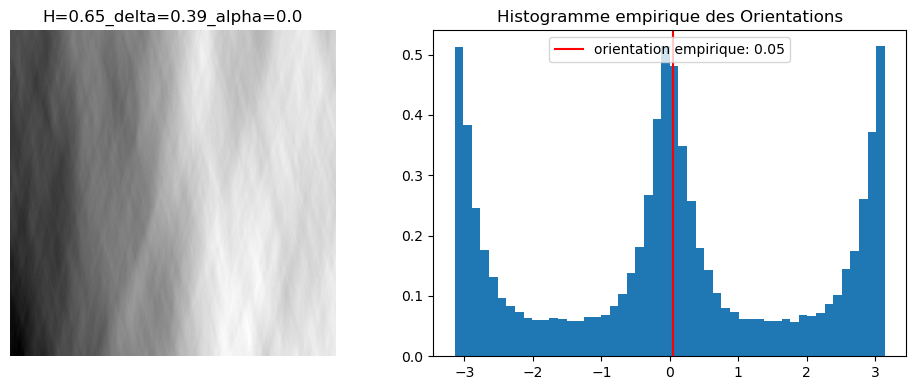

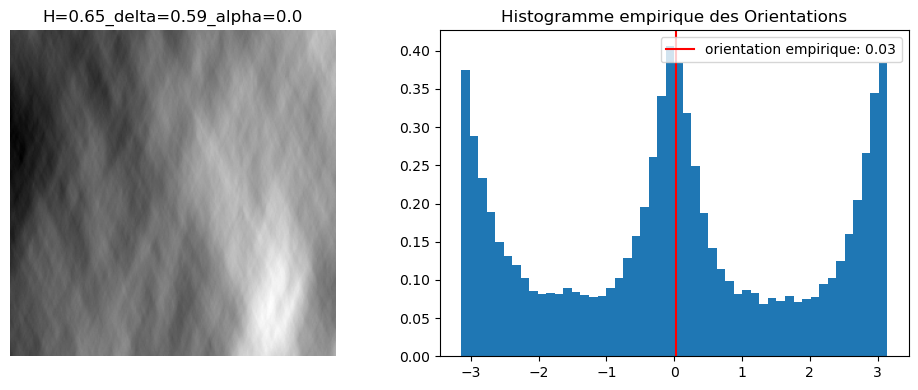

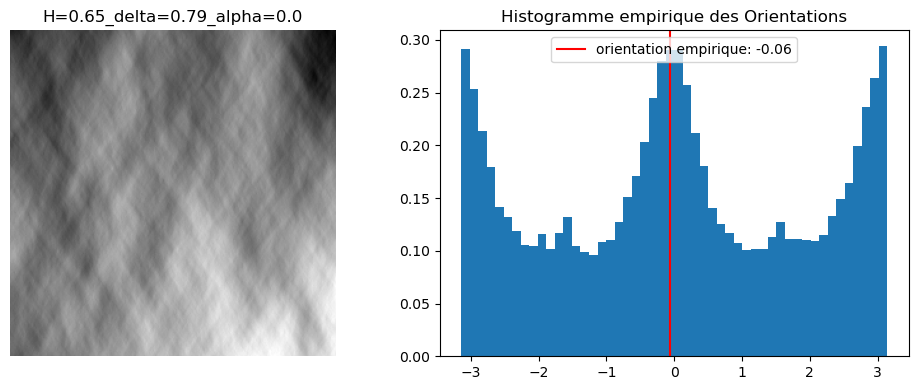

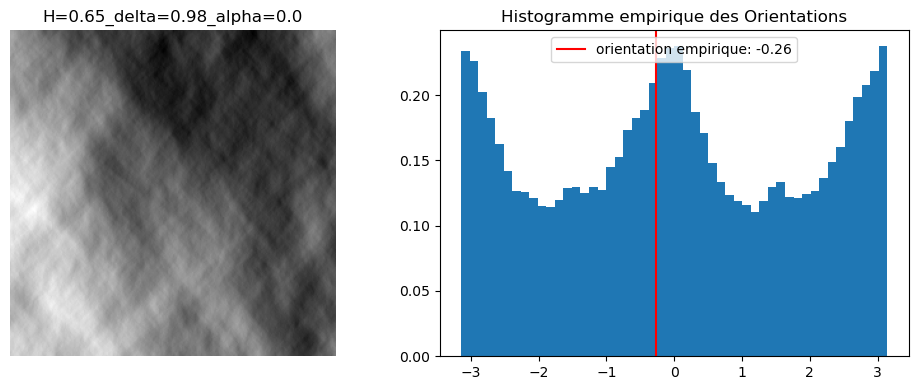

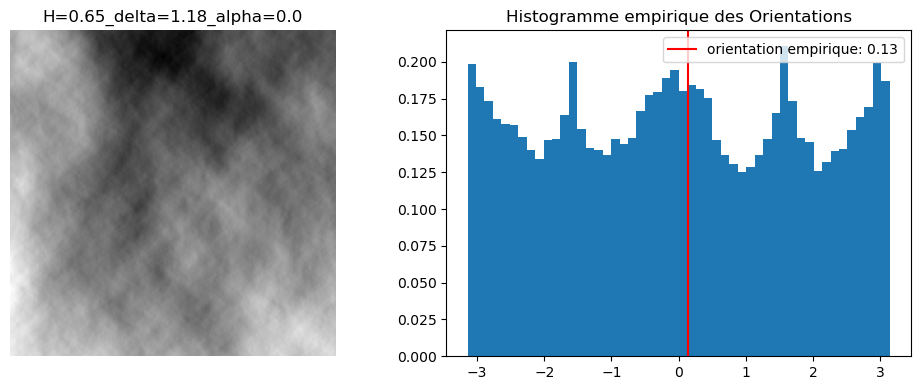

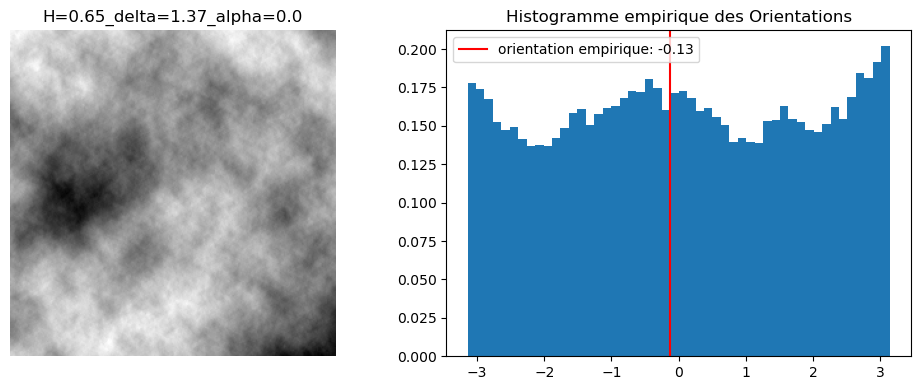

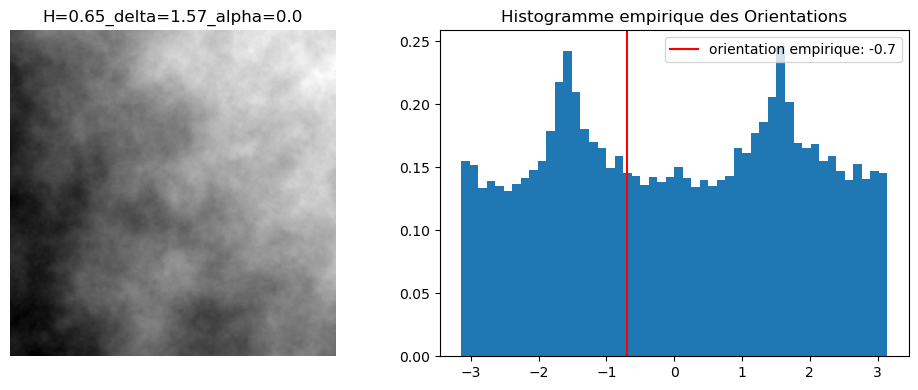

In [44]:
for delta in delta_set:
        X,title=load_img_200_of(H=0.65,delta=delta,alpha=alpha,index=index)
        show_OE_emphists_OL(X,title=title)

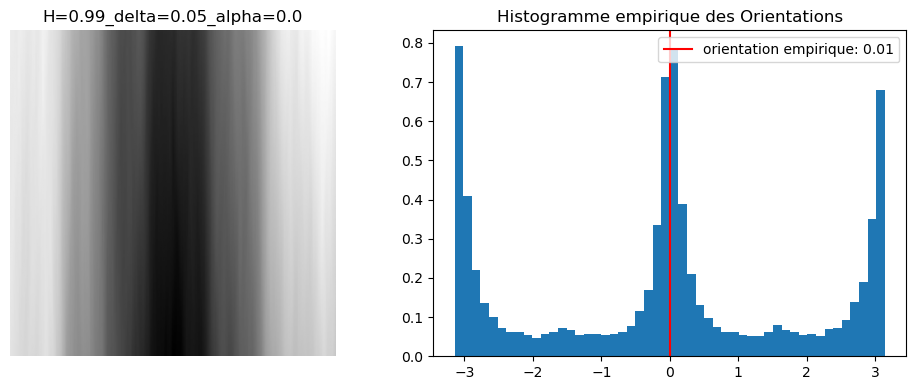

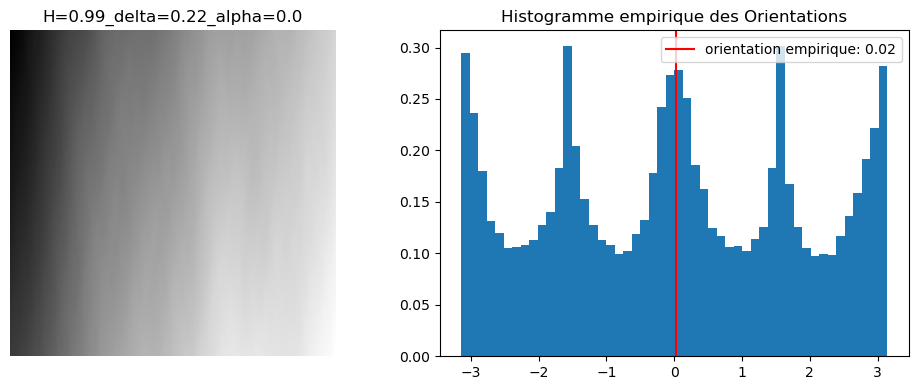

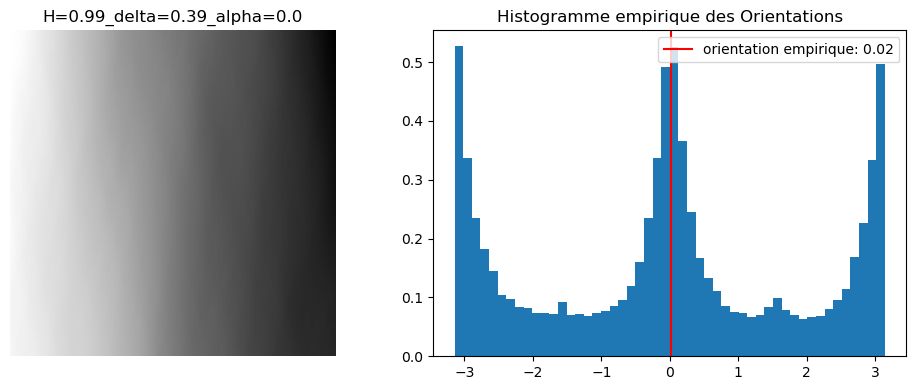

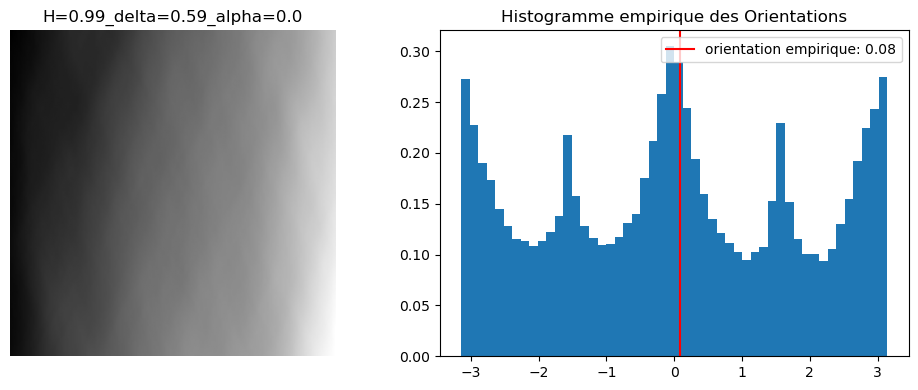

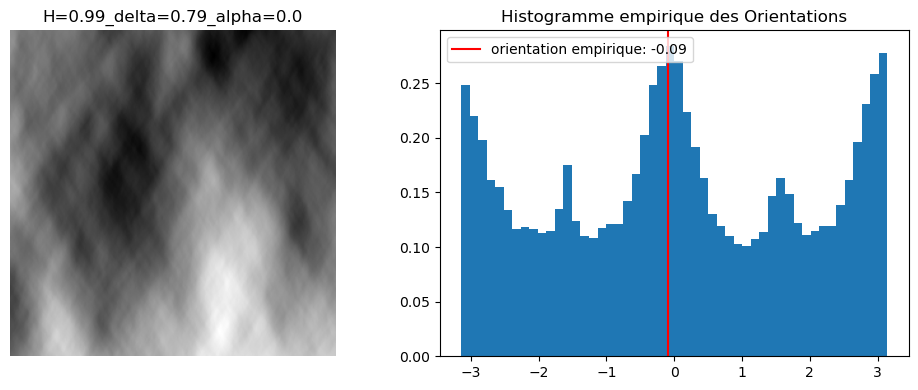

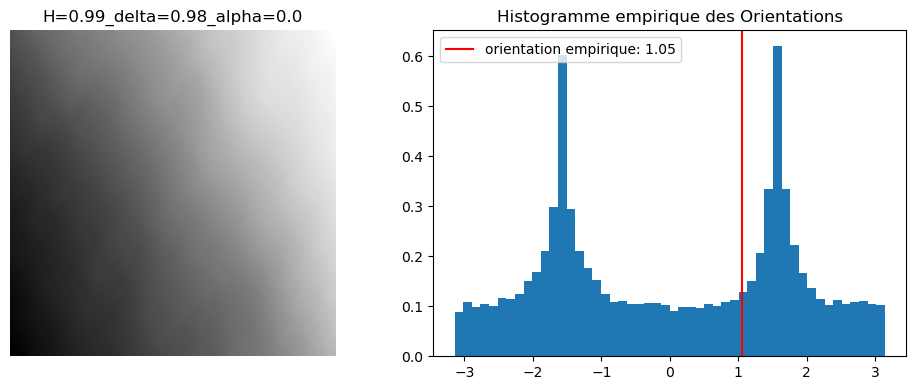

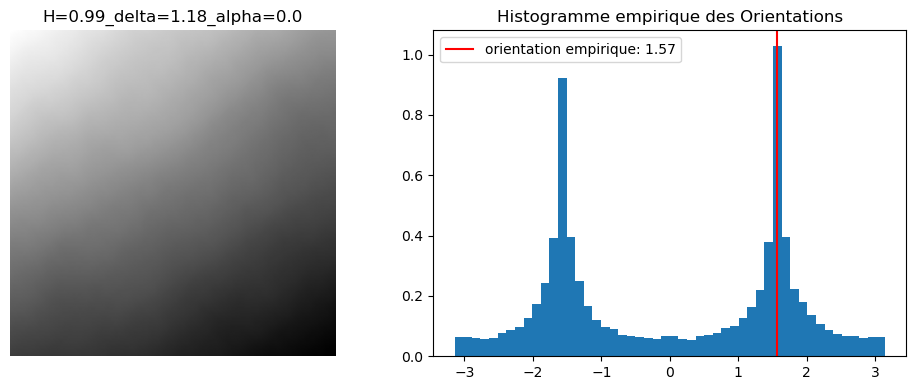

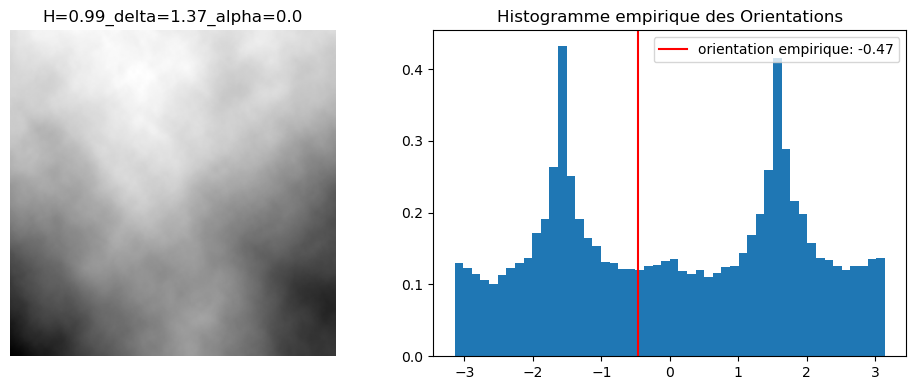

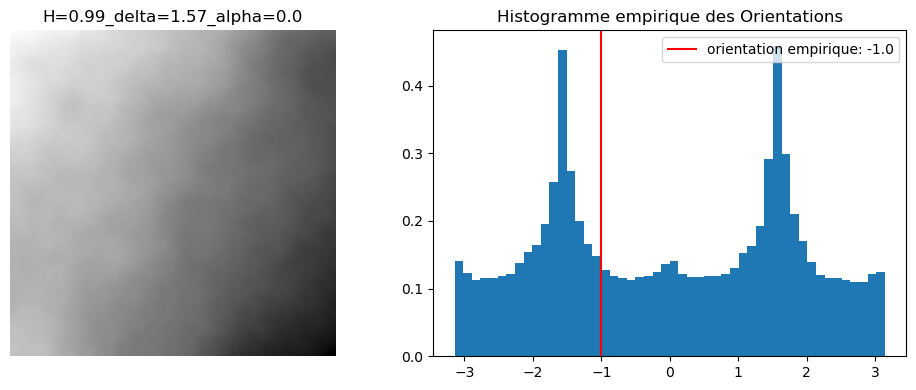

In [46]:
for delta in delta_set:
        X,title=load_img_200_of(H=0.99,delta=delta,alpha=alpha,index=index)
        show_OE_emphists_OL(X,title=title)

In [9]:
##################################### Calcul de l'esperance de l'estimateur de alpha pour une valeur de delta #########################
def meanof_alpha_estimator(H=0.5,delta=pi/64,alpha=0.0,nb_realst=25,l=3,c_n=0.014):
    '''
    Entrées:\n'
    H: Ordre d'autosimilarité théorique\n
    delta: Degré d'anistropie théorique\n
    nb_realst: Nombre de réalisation du champ\n
    l: Échelle \n
    c_n: Constante de normalisation \n
    Sortie:\n'
    Orientation moyenne de la texture
    '''
    mean=0
    for index in range(nb_realst):
        X,_=load_img_200_of(H=H,delta=delta,alpha=alpha,index=index)
        mean+=alpha_estimator(X,l,c_n)/nb_realst   # Calcul de l'orientation empirique moyenne pour une valeur de H et delta
    return mean

meanof_alpha_estimator(H=0.5,delta=pi/64,alpha=-pi/2,nb_realst=25,l=3,c_n=0.014)

-0.31336997192387633

In [10]:
############################# Illustration graphique de l'efficacité de estimateur de alpha en fonction de delta du champ EF ##################################
def AverageOrientation_estimator(delta,nb_realst,c_n=0.014,l=3):
    '''
    Entrées:\n'
    delta: Degré d'anisotropie des textures
    nb_realst: Nombre de réalisation du champ\n
    c_n: Constante de normalisation \n
    l: Éclhelle adéquate\n
    Sortie:\n'
    Figure illustrative de l'éfficacité de l'estimateur à estimer, par sa moyenne, l'orientation des textures
    '''
    #plt.figure(figsize=(5,3),dpi=100)
    couleurs=[(0.25,1,0.7),'0.35','g','r','c','m','y','b',(1,0.25,0.7),(0.5,0.7,1)]
    H_set_=H_set_o#[1:7]
    for i,alpha_i in enumerate(alpha_set_o):
        mean_emp_orit_alpha=np.zeros((len(H_set_),))
        for j,H in enumerate(H_set_):
            mean_emp_orit_alpha[j]=meanof_alpha_estimator(H,delta,alpha_i,nb_realst,l=l,c_n=c_n)# Calcul de l'orientation empirique moyenne pour une valeur de H
        plt.axhline(alpha_i,ls='--',c=couleurs[i])                                              # Tracé de l'orientation du champ en fonction de H
        plt.plot(H_set_,mean_emp_orit_alpha,ls='-',label='$\\tilde{{\\alpha}_{0,3}}$('+alpha_set_str_o[i]+')',c=couleurs[i]) # Tracé de l'estimateur en fonction de H
    plt.xticks(H_set_,H_set_.astype(str),rotation=45)
    plt.xlabel('Indice de rugosité H')
    plt.yticks(alpha_set_o,alpha_set_str_o)
    plt.ylabel('Orientation cible')
    plt.title("Estimateur de l'orientation moyenne pour $\\delta$="+delta_set_str_o[delta_set_o==delta][0])
    plt.legend(loc="upper left")
    plt.tight_layout()
    #plt.savefig(fil_dir+"Orient_emp_moy_H_"+str(delta)+".png")

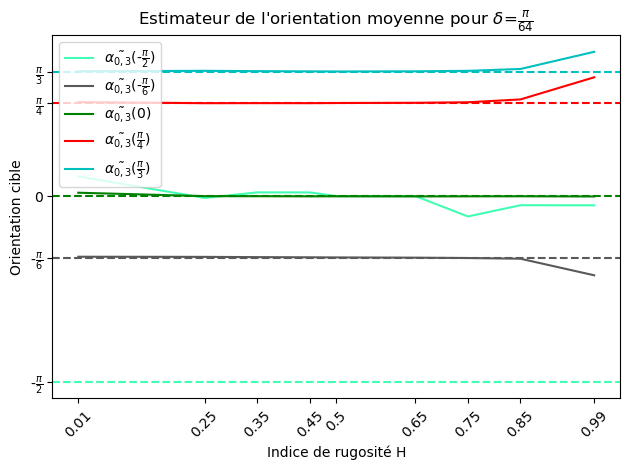

In [11]:
AverageOrientation_estimator(pi/64,nb_realst=200,c_n=0.014,l=3)

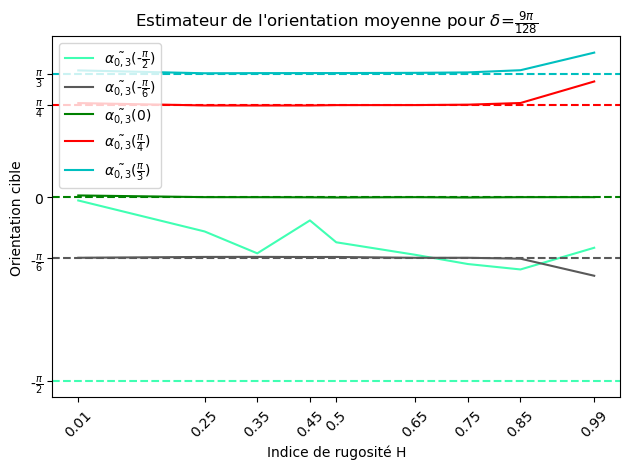

In [54]:
AverageOrientation_estimator(9*pi/128,nb_realst=200,c_n=0.014,l=3)

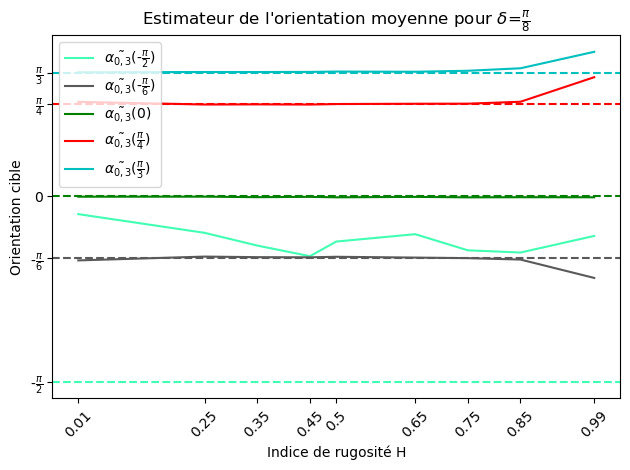

In [55]:
AverageOrientation_estimator(pi/8,nb_realst=200,c_n=0.014,l=3)

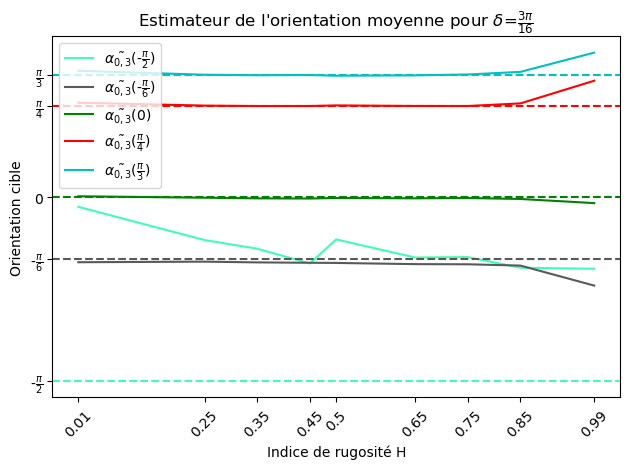

In [56]:
AverageOrientation_estimator(3*pi/16,nb_realst=200,c_n=0.014,l=3)

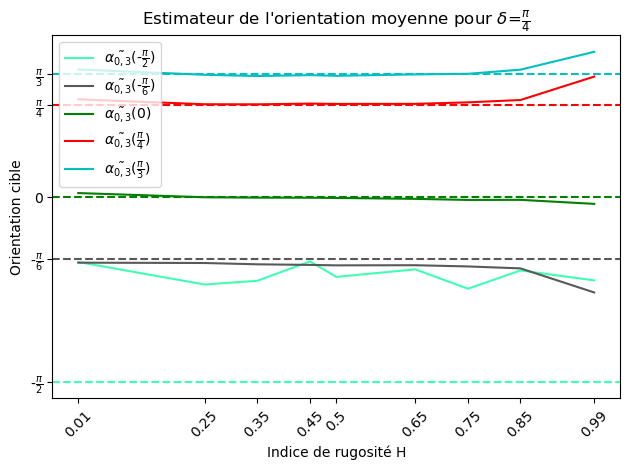

In [57]:
AverageOrientation_estimator(pi/4,nb_realst=200,c_n=0.014,l=3)

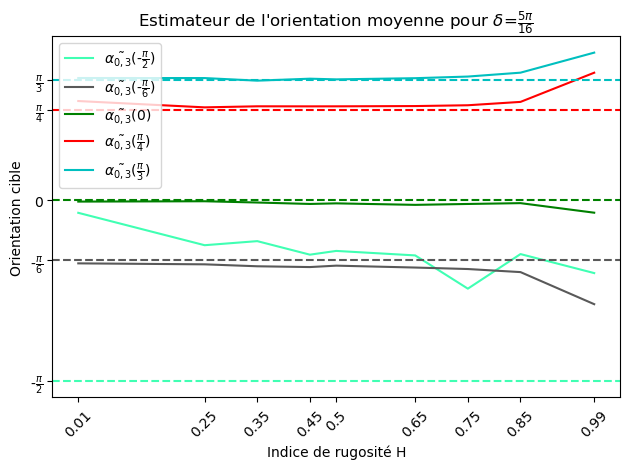

In [58]:
AverageOrientation_estimator(5*pi/16,nb_realst=200,c_n=0.014,l=3)

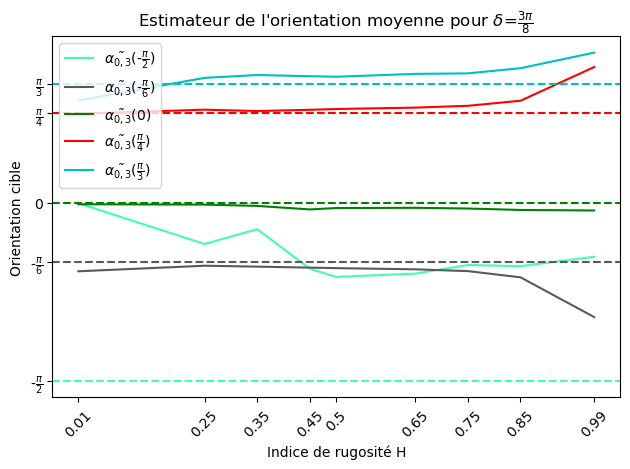

In [59]:
AverageOrientation_estimator(3*pi/8,nb_realst=200,c_n=0.014,l=3)

Ces figures illustrent une estimation de l'orientation moyenne(en couleur) d'une texture en fonction de l'ordre d'autossimilarité H pour differents degrés d'anisotropies $\delta$. 
Nous nous attendons à des valeurs estimées presque identiques pour chaque orientation $\alpha$ (en couleur).
- l'estimation est satisfaisante pour $0.01\le H < 0.85$, $\delta < \frac{5\pi}{16}$ et $\alpha \ne \frac{-\pi}{2}$.
- Ces mauvais resultats:
    - par rapport à H est du fait d'une faible (en dessous de la ligne en tirait) ou forte (au dessus de la ligne en tirait) énergie,dans le domaine frequentiel, de la texture filtrée.
    - en  $\frac{-\pi}{2}$ est du fait que c'est une borne du support de la fonction de topothésie.
- Plus la ligne en trait plein est proche de celle en tirait plus l'estimateur est efficace(Notion justifiée par les taleaux de MSE et VE ci-dessous)

In [ ]:
# Calcul de la moyenne quadratiue(Mse) et de la variance empirique(ve) de l'estimateur de l'orientation
def mse_ve_alpha_estimator(H,nb_realst=25,n=None):
    '''
    Entrées:\n'
    H: Ordre d'autosimilarité.
    nb_realst: Nombre de réalisation du champ.\n
    l: Échelle. \n
    n: Nombre de valeurs du degré d'anisotropie nécessaires pour estimer un seuil d'efficacité de l'estimateur.\n
    Sortie:\n'
    Deux tableaux contenant respectivement les moyennes quadratiues et les variances empiriques de l'estimateur de l'ordre d'autosimilarité 
    pour chaque texture de paramètres théoriques H et delta
    '''
    
    MSE=np.zeros((len(alpha_set_o),len(delta_set_o[:n])));VE=np.zeros((len(alpha_set_o),len(delta_set_o[:n])))
    
    for i,alpha_i in enumerate(alpha_set_o):
        for j,delta in enumerate(delta_set_o[:n]):
            mean=meanof_alpha_estimator(H,delta,alpha_i,nb_realst)       # Calcule de  de lesperance de l'estimateur(moyenne empirique des orientations empiriques)
            ve=0;mse=0
            for index in range(nb_realst):
                X,_=load_img_200_of(H=H,delta=delta,alpha=alpha_i,index=index)
                tild_alpha=alpha_estimator(X)                                   # Calcul d'une valeur de alpha estimée
                ve+=(tild_alpha-mean)**2/nb_realst                              # Calcul de la variance empirique
                mse+=(tild_alpha-alpha_i)**2/nb_realst                                # Calcul de l'erreur moyenne quadratique

            MSE[i,j]=mse;VE[i,j]=ve
        
    return  pd.DataFrame(MSE,index=alpha_set_str_o,columns=delta_set_str_o[:n]),pd.DataFrame(VE,index=alpha_set_str_o,columns=delta_set_str_o[:n])

In [ ]:
#MSE,VAR=mse_ve_alpha_estimator(H=0.5,nb_realst=200,n=7)# 25/3,16mn ******************** 24,8mn
#MSE.round(5).to_csv(fil_dir+'mse_tild_alpha.csv',sep=';',index=True,header=True)
#VAR.round(5).to_csv(fil_dir+' var_tilde_alpha.csv',sep=';',index=True,header=True)

In [18]:
mse=pd.read_csv(fil_dir+'mse_tild_alpha.csv',sep=";")
mse

Unnamed: 0  $\frac{\pi}{64}$  $\frac{9\pi}{128}$  $\frac{\pi}{8}$  \
0  -$\frac{\pi}{2}$           4.91670             3.66347          3.64978   
1  -$\frac{\pi}{6}$           0.00006             0.00051          0.00102   
2                 0           0.00009             0.00054          0.00114   
3   $\frac{\pi}{4}$           0.00004             0.00041          0.00085   
4   $\frac{\pi}{3}$           0.00006             0.00046          0.00102   

   $\frac{3\pi}{16}$  $\frac{\pi}{4}$  $\frac{5\pi}{16}$  $\frac{3\pi}{8}$  
0            3.68831          2.66341            3.34226           2.56259  
1            0.00295          0.00622            0.00778           0.01490  
2            0.00213          0.00355            0.00629           0.01589  
3            0.00144          0.00325            0.00617           0.01239  
4            0.00184          0.00323            0.00538           0.01461

In [21]:
ve=pd.read_csv(fil_dir+' var_tilde_alpha.csv',sep=";")
ve

Unnamed: 0  $\frac{\pi}{64}$  $\frac{9\pi}{128}$  $\frac{\pi}{8}$  \
0  -$\frac{\pi}{2}$           2.45056             2.26107          2.23696   
1  -$\frac{\pi}{6}$           0.00004             0.00037          0.00086   
2                 0           0.00009             0.00053          0.00108   
3   $\frac{\pi}{4}$           0.00004             0.00041          0.00084   
4   $\frac{\pi}{3}$           0.00003             0.00034          0.00091   

   $\frac{3\pi}{16}$  $\frac{\pi}{4}$  $\frac{5\pi}{16}$  $\frac{3\pi}{8}$  
0            2.22129          1.86363            2.06480           1.72292  
1            0.00156          0.00322            0.00575           0.01201  
2            0.00210          0.00353            0.00555           0.01356  
3            0.00144          0.00312            0.00524           0.01095  
4            0.00180          0.00310            0.00537           0.01094

**Remarque:** Plus la texture est isotrope moins l'estimateur est efficace

In [61]:
def meanof_emp_alpha_per_delta(H,nb_realst,c_n=0.014,l=3):
    #plt.figure(figsize=(5,3))
    couleurs=[(0.25,1,0.7),'0.35','g','r','c','m','y','b',(1,0.25,0.7),(0.5,0.7,1)]
    #H_set_0=H_set_o[1:]
    
    for i,alpha in enumerate(alpha_set_o):
        meanof_emp_orit_per_delta=np.zeros((len(delta_set_o),))
        for j,delta in enumerate(delta_set_o):
            for index in range(nb_realst):
                X,title=load_img_200_of(H,delta,index,alpha=alpha)                        # chargement du champ         
                val_p,vect_p=np.linalg.eig(tsore(X,l,c_n))
                vect_p_max=vect_p[:,np.argmax(val_p)]
                meanof_emp_orit_per_delta[j]+=np.arctan(vect_p_max[1]/vect_p_max[0])/nb_realst # orientation empirique du champ
        plt.axhline(alpha,ls='--',c=couleurs[i])
        plt.plot(delta_set_o,meanof_emp_orit_per_delta,ls='-',label='$\\tilde{{\\alpha}_{0,3}}$('+alpha_set_str_o[i]+')',c=couleurs[i])
    plt.xticks(delta_set_o,delta_set_str_o,rotation=45)
    plt.xlabel("Degré d'anisotropie"+'$\\delta$')
    plt.yticks(alpha_set_o,alpha_set_str_o)
    plt.ylabel('Orientation cible')
    plt.title('orientation_empirique_moyenne pour H='+str(H))
    plt.legend(loc="upper left",bbox_to_anchor=(1,1))
    plt.savefig(fil_dir+"orient_emp_moy_per_delta_"+str(H)+".png")

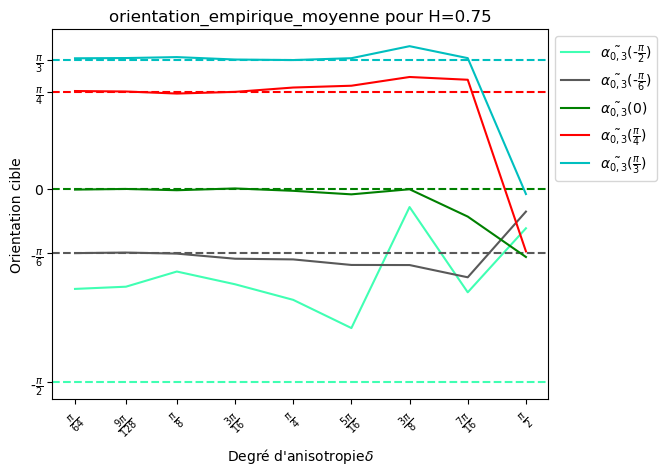

In [62]:
meanof_emp_alpha_per_delta(H=0.75,nb_realst=25,c_n=0.014,l=3)#25/2,25mn